# Tutorial on how to fit emission line and use IFU data - KMOS/SINFONI/JWST etc

Here I am going to go through basic of analysing IFU data and fitting emission lines. First, in order to quickly look at IFU cubes, I recommend QFits. https://www.mpe.mpg.de/~ott/QFitsView/. 

To read more about Integral Field Spectroscopy, I recommend section 2.2 of my thesis: http://etheses.dur.ac.uk/13311/1/Thesis_cor_mk_II.pdf?DDD25+ or from Chris Harrison; Chapter 2. http://etheses.dur.ac.uk/10744/1/cmh_thesis.pdf?DDD25+


# Dealing wih IFU data

We will first start with loading the cube and extracting a spectrum. We will then continue to write a simple fitting code to fit the spectrum from the previous tutorial. 

Lets start with importing basic libraries. This is a start of every code I write. 

In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23



PATH='/Users/jansen/My Drive/Astro/'


## Loading the JWST IFS cube. 

We will now load the IFU cube and extract all of the import information. We need to extract the wavelength grid and the data cube and the header information. 

In [2]:
path = '/Users/jansen/JADES/GA_NIFS/IFS_data_v1/' 
file_name = '5001-GS-3.47-S_jw1216_o005_ff_px0.05_drizzle_ODfde98_3_VSC_MRC_MSA_m2ff_CTX1068.pmap_v1.8.2_g235h-f170lp_cgs_s3d.fits' # Full path to the file

Full_path = path + file_name

with pyfits.open(Full_path, memmap=False) as hdulist:

    Flux_cube = hdulist['SCI'].data *1e4 * 1e15
    Header = hdulist['SCI'].header

    n_channels = Header['NAXIS3'] # Extract the number pixels in the third axis (wavelength)
    obs_wave = Header['CRVAL3'] + (np.arange(n_channels) - (Header['CRPIX3'] - 1.0))*Header['CDELT3'] # Extract the wavelength grid


z = 3.471

plt.show()


## Extracting a spectrum from multiple spaxel together - circular aperture 

The best thing about IFS is that we extract spectrum from anywhere in the galaxy to investigate the properties in that section. We can use a very simple circular mask to setup to create a spectrum with a sum of all of the spaxels. 

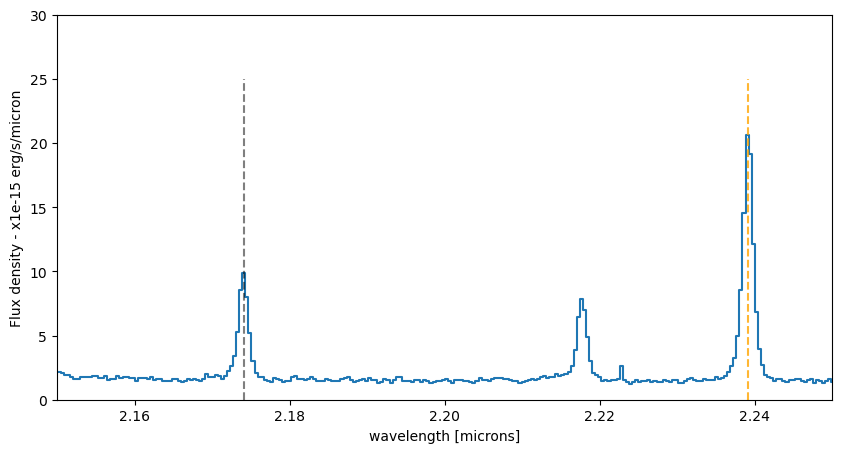

In [3]:
def sp_circ_ap(cenx,ceny,rad,Flux_cube):

    nwl = len(Flux_cube[:,0,0])
    nx = len(Flux_cube[0,0,:])
    ny = len(Flux_cube[0,:,0])
    # creates array with one spectrum per row
    intermarray = np.full((nwl,nx*ny), np.nan)
    # fills it with nans
    
    nloop = 0
    # loop on data
    for x in range(nx) :
        for y in range(ny) :  
            distance = np.sqrt((x-cenx)**2+(y-ceny)**2)
            if distance < rad :
                intermarray[:,int(nloop)] = Flux_cube[:,int(y),int(x)]
                nloop += 1
               
    # average
    outspec = np.nansum(intermarray,axis=1)
    return outspec

# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(44,47,5,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.500824*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.65645*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.486263*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.673267*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.15,2.25)
ax.set_ylim(-0.,30.)

plt.show()

We can see a very bright detection of narrow [OIII], but there is also a fainter line right next to it at 2.21 and 2.23 microns. This is the other part of [OIII] doublet and Hbeta line. There is one at restframe 4960 and 4861 angstroms. When fitting the [OIII]5008, we wil have to fit the [OIII] 4960 (full doublet) as well and the Hbeta 4861. 

So in summary we will be fitting the following models: 
1) [OIII]5008,4960 - single Gaussian to each member of the [OIII] doublet.  
2) Hbeta  - one gaussian components
4) Continuum - We need to fit the continuum. KMOS and SINFONI are not very sensitive to the features of the continuum hence fitting a line with gradient and normalization is enough. For high SNR data (maybe from JWST?) or local galaxies we would have to fit ppxf models - I have never done it though. 

However, we do not need to fit 3 parameters for each gaussian (peak, location and width) as we can make some assumptions and use some physics.
1) First of all we will assume that all of these emission lines are coming from the same gas - hence they will have the same redshift
2) Because they are coming from the same gas, they have the samw width - sigma (or FWHM) of the line
3) The [OIII] has fixed line ratio between the two lines - the [OIII]4960 line has 1/3 of the flux of the [OIII]5008 line. Since the width of these lines is the same, we can say that the ratio of the peaks of these two lines is 2.99. 

This drastically reduces the amount of free parameters - from 11 to 6. 

In order to fit these models we will use least square fitting. 

In [4]:
# Defining the model for fitting emission lines around Halpha including of course Halpha itself. 
# Setting up a single Gaussian - will be used later 
def gauss(x, k, mu,FWHM):
    sig = FWHM/2.35482/3e5*mu
    expo= -((x-mu)**2)/(2*sig*sig) 
    y= k* e**expo
    return y

# Setting up the Halpha model:
# First we calculate the observed frame wavelengths of the lines
# Then we calculate the individfual components - Halpha, [NII] and [SII]
# Finally we add all of them together
def OIII_Hbeta(x, z, cont,cont_grad,  OIII_peak, Hbeta_peak, Nar_fwhm):
    OIIIr_wv = 5008.24*(1+z)/1e4    
    OIIIb_wv = 4960.*(1+z)/1e4
    Hbeta_wv = 4862.6*(1+z)/1e4
    
    OIII_nar = gauss(x, OIII_peak, OIIIr_wv, Nar_fwhm) + gauss(x, OIII_peak/2.99, OIIIb_wv, Nar_fwhm)

    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta_wv, Nar_fwhm)
    continuum = cont+x*cont_grad

    return continuum+ OIII_nar + Hbeta_nar


Next we will prep the data for fitting:
1) will only include channels (data) that was not masked. 

2)  We are not really interested in fitting the whole spectral window. We are only interested in the range our the spectral line. I like to go +- 300 angstroms around the line.

3) Lastly, we need to find the value of the peak of the line - we will use this when creating initial conditions. 

In [5]:
flux = D1_spec.data[np.invert(D1_spec.mask)]
wave = obs_wave[np.invert(D1_spec.mask)]
    
fit_loc = np.where((wave>(5008-300)*(1+z)/1e4)&(wave<(5008+300)*(1+z)/1e4))[0]
       
sel=  np.where(((wave<(5008+20)*(1+z)/1e4))& (wave>(5008-20)*(1+z)/1e4))[0]
flux_zoom = flux[sel]
wave_zoom = wave[sel]
    
peak_loc = np.ma.argmax(flux_zoom)
peak = np.ma.max(flux_zoom)

import astropy.stats as stats
sigma = stats.sigma_clipped_stats(flux_zoom, sigma=3, maxiters=5)[2]
# sigma is the standard deviation of the flux in the selected region
error = np.ones_like(flux) * sigma

# Least Square fitting

We are going to first look into least square fitting, using the scipy's curve_fit function - box standard

In [6]:
from scipy.optimize import curve_fit

init_c = [z,np.median(flux),0.01, peak, peak/4, 300. ]

popt_oiii, pcov_oiii = curve_fit(OIII_Hbeta, wave[fit_loc], flux[fit_loc], sigma= error[fit_loc], p0= init_c) 

In [7]:
np.savetxt('/Users/jansen/Downloads/1D_spec_example.txt', (wave, flux, error))
x,y,zs = np.loadtxt('/Users/jansen/Downloads/1D_spec_example.txt') 



In [8]:
from astropy.table import Table

Save = Table()

Save['wave'] = obs_wave
Save['flux'] = D1_spec.data
Save.write('/Users/jansen/Downloads/1D_spec_example.csv', format='csv', overwrite=True)
Save.write('/Users/jansen/Downloads/1D_spec_example.fits', overwrite=True)

Spec = Table.read('/Users/jansen/Downloads/1D_spec_example.csv', format='csv')
print(Spec)

flux = Spec['flux']

       wave               flux       
------------------ ------------------
 1.660483055066942  2.621318293560762
 1.660879055055483  2.593050110852346
 1.661275055044024 2.3017599475570023
 1.661671055032565  2.241461842088029
 1.662067055021106 2.6046728030778468
 1.662463055009647 3.0533096530707553
 1.662859054998188  2.828475203103153
 1.663255054986729 3.0318664484657347
  1.66365105497527  2.840918460424291
1.6640470549638111  3.178369312081486
               ...                ...
3.1656790115113096 1.0068154379841872
3.1660750114998506 1.0345194077817723
3.1664710114883916 0.9416091310267802
3.1668670114769326 0.9288875252241269
3.1672630114654736  0.961167388872127
3.1676590114540146 0.9327957495115697
3.1680550114425556 0.7783765411586501
3.1684510114310966 0.7275521180999931
3.1688470114196376 0.6988272720336681
3.1692430114081787 0.8252436321199639
Length = 3811 rows


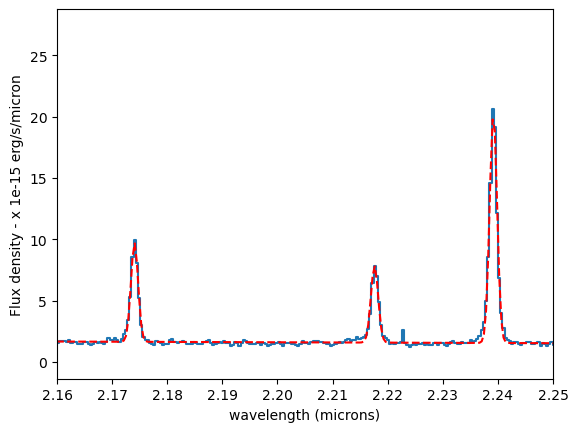

In [9]:
plt.figure()
plt.plot( wave, flux, drawstyle='steps-mid')
plt.xlabel('wavelength (microns)')
plt.ylabel('Flux density - x 1e-15 erg/s/micron')
plt.plot(wave, OIII_Hbeta(wave, *popt_oiii), 'r--')

plt.xlim(2.16, 2.25)

plt.show()

In [10]:
print('Best_fit value', popt_oiii)
print('1 sigma errors', np.sqrt(np.diag(pcov_oiii)))


Best_fit value [  3.47098829   4.88276691  -1.49486891  18.6298935    8.03673543
 212.57917305]
1 sigma errors [9.42293626e-06 2.03378297e-01 9.07418672e-02 1.19087047e-01
 1.10565888e-01 1.49754636e+00]


### Calculating SNR

we will now calculate the SNR of the line. This can be tricky for emission line, as we need to take into consideration not just the peak channel, but also other inside the emission line profile.

The equation we use is as follows: 
\begin{equation}
SNR =  \frac{\sum_i \rm flux_i}{ (\sum_i error_i^2)^{1/2}} 
\end{equation}

Assuming that the errors per channel are the same:

\begin{equation}
SNR = \frac{1}{\sqrt n} \sum \frac{ \rm flux \space  density}{\rm error}
\end{equation}

where the flux is the the flux density values at each channel within certain velocity/wavelength range, sigma is the uncertanties on the flux densities (error) and the n is the number of channels across the range of the emission line. 

In [11]:
wv0 = 5008*(1+popt_oiii[0])/1e4
fwhm = popt_oiii[-1]
fwhm_wv = fwhm/3e5*wv0
eml_model = gauss(wave,popt_oiii[3], wv0 , fwhm) 


use = np.where( ((wv0-fwhm_wv)<wave) & (wave< (wv0+fwhm_wv)))[0]
flux_sel = eml_model[use]

n = len(use)
SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[100])
print('SNR of the [OIII] line :', SNR)

SNR of the [OIII] line : 90.3868911615822


the alternative way is to calculate it dirrectly from the MCMC as integrated flux/ error on the integrated flux. See how to caluclate the integrated flux below!\frac{1}{\sqrt{n}}


## Estimating the integrated flux of the line

It is now time to calculate all the properties of the line. The way we setup the fitting, we imddiatly have the emission line width (as FWHM in velocity space), redshift (location of the line). We now need to estimate the total integrated flux of the line. Luckily, for this we just need to integrate the flux density (flux per unit of wavelength) to get total flux. 

Unlike with SNR, the equation for flux is not dependant on the number of channels so we integrate the gaussian across all the channels (The Gaussian far away from our line is going to be 0, or very close to it). 

In [ ]:
import scipy.integrate as scpi # we will use scipy's integrate simpsons function to do this
            
wv0 = 5008*(1+popt_oiii[0])/1e4
fwhm = popt_oiii[-1]

a = 1./(2*(fwhm/3e5*wv0/2.35482)**2)
Flux_OIII = popt_oiii[3]*np.sqrt(np.pi/a) *1e-15 # Remember when I said that we normalize the spectrum earlier? That where the 1e-15 factor comes in


print('Flux of the [OIII] line is: ', Flux_OIII, 'ergs/s/cm-2')

wv0 = 4860*(1+popt_oiii[0])/1e4
fwhm = popt_oiii[-1]

a = 1./(2*(fwhm/3e5*wv0/2.35482)**2)
Flux_Hbeta = popt_oiii[4]*np.sqrt(np.pi/a) *1e-15 # Remember when I said that we normalize the spectrum earlier? That where the 1e-15 factor comes in

print('Flux of the Hbeta line is: ', Flux_Hbeta, 'ergs/s/cm-2')


Flux of the line is:  3.146370792496217e-17 ergs/s/cm-2
Flux of the line is:  1.317198265055217e-17 ergs/s/cm-2


## Fitting the Halpha + [NII]

We can fit the spectrum this high SNR spectrum based on the skills we have learned in the previous notebook. The setup is going to be very similar but we will fit the Halpha. The Halpha is close to other emission lines - [NII] doublet and [SII] doublet. 

I have pre written part of the function below. However remember that the flues of [NII] doublet is 6585 and 6549 is tied together by a factor of 3 - similar to the [OIII] doublet in the previous notebook. Finally the [SII] doublet ratio is free.  

In [13]:
# Defining the model for fitting emission lines around Halpha including of course Halpha itself. 
# Setting up a single Gaussian - will be used later 
def gauss(x, k, mu,FWHM):
    sig = FWHM/2.35482/3e5*mu
    expo= -((x-mu)**2)/(2*sig*sig) 
    y= k* e**expo
    return y

# Setting up the Halpha model:
# First we calculate the observed frame wavelengths of the lines
# Then we calculate the individfual components - Halpha, [NII] and [SII]
# Finally we add all of them together
def Halpha_NII_SII(x, z, cont,cont_grad,  Hal_peak, NII_peak, SIIr_peak, SIIb_peak, Nar_fwhm):
    Hal_wv = 6564.52*(1+z)/1e4
    NII_r = 6585.27*(1+z)/1e4
    NII_b = 6549.86*(1+z)/1e4

    SII_r = 6732.67*(1+z)/1e4
    SII_b = 6718.29*(1+z)/1e4

    Hal_nar = gauss(x, Hal_peak, Hal_wv, Nar_fwhm)

    NII_nar = gauss(x, NII_peak, NII_r,  Nar_fwhm) + gauss(x, NII_peak/3, NII_b,  Nar_fwhm)
    SII_nar  = gauss(x, SIIr_peak, SII_r,  Nar_fwhm)  + gauss(x, SIIb_peak, SII_b,  Nar_fwhm)

    continuum = cont+x*cont_grad

    return continuum+ Hal_nar + NII_nar + SII_nar


Next we will prep the data for fitting:
1) will only include channels (data) that was not masked. 

2)  We are not really interested in fitting the whole spectral window. We are only interested in the range our the spectral line. I like to go +- 300 angstroms around the line.

3) Lastly, we need to find the value of the peak of the line - we will use this when creating initial conditions. 

In [14]:
# Adjust these number to be around Halpha emission line 
fit_loc = np.where((obs_wave>(6564-300)*(1+z)/1e4)&(obs_wave<(6564+300)*(1+z)/1e4))[0] 

sel=  np.where(((obs_wave<(6564+20)*(1+z)/1e4))& (obs_wave>(6564-20)*(1+z)/1e4))[0]
flux_zoom = D1_spec[sel]
wave_zoom = obs_wave[sel]

peak_loc = np.ma.argmax(flux_zoom)
peak = np.ma.max(flux_zoom)

 # Estimate the error as the standard deviation of the flux in the fit region with 3 sigma clipping
import astropy.stats as stats
error = np.full_like(D1_spec, stats.sigma_clipped_stats(D1_spec[fit_loc], sigma=3)[2])

## Least Square fitting

We are going to first look into least square fitting, using the scipy's curve_fit function - box standard

In [15]:
from scipy.optimize import curve_fit

# Change initial conditions to match the variables in the function 
init_c = [z,np.median(D1_spec),0.01, peak, peak/7,peak/15,peak/15, 200. ]

popt_hal, pcov_hal = curve_fit(Halpha_NII_SII, obs_wave[fit_loc], D1_spec[fit_loc], sigma= error[fit_loc], p0= init_c) 

/Users/jansen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


[  3.47109348   1.6487831   -0.21863866  25.63187733   6.26661411
   1.50705394   1.95313375 205.30344357] [9.63458318e-06 4.01110868e-01 1.36716538e-01 1.68789803e-01
 1.35045285e-01 1.39349547e-01 1.39422631e-01 1.53153212e+00]


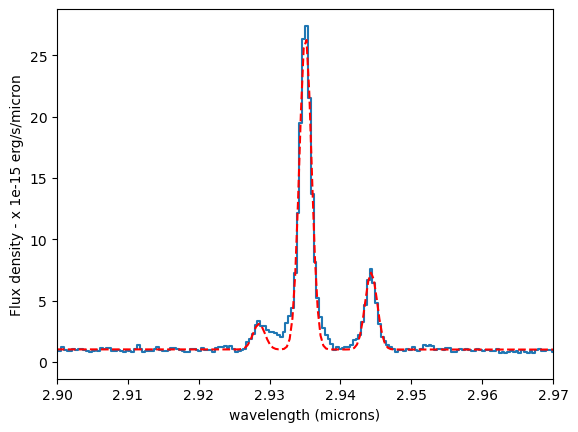

In [21]:
plt.figure()
plt.plot( wave, flux, drawstyle='steps-mid')
plt.xlabel('wavelength (microns)')
plt.ylabel('Flux density - x 1e-15 erg/s/micron')
plt.plot(wave, Halpha_NII_SII(wave, *popt_hal), 'r--')


print(popt_hal, np.sqrt(np.diag(pcov_hal)))

plt.xlim(2.9,2.97)
plt.show()

## Extracting valuable information from the fits

1) Now using the information we used in the 1_Emission_line_tutorial, you can estimate the flux of the different emission lines, their SNRs and FWHM and redshifts. 

2) Also you should fit the OIII+Hbeta emission lines and estimate its fluxes, SNR etc. 

In [17]:
# Extract Emission line parameters from the fit

def flux_calc(index, rest_wave, popt):
                
    wv0 = rest_wave*(1+popt[0])/1e4
    fwhm = popt[-1]

    a = 1./(2*(fwhm/3e5*wv0/2.35482)**2)
    Flux = popt[index]*np.sqrt(np.pi/a) *1e-15 # Remember when I said that we normalize the spectrum earlier? That where the 1e-15 factor comes in

    return Flux

Flux_hal =  flux_calc(3, 6564.52, popt_hal)
Flux_NII = flux_calc(4 ,6584.52, popt_hal)
Flux_SIIr = flux_calc(5, 6732.67, popt_hal)
Flux_SIIb = flux_calc(6, 6718.29, popt_hal)
print('Halpha_flux', Flux_hal, 'ergs/s/cm-2')
print('NII_flux', Flux_NII, 'ergs/s/cm-2')
print('SIIr_flux', Flux_SIIr, 'ergs/s/cm-2')
print('SIIb_flux', Flux_SIIb, 'ergs/s/cm-2')


def SNR_calc(index, rest_wave, popt):
    wv0 = rest_wave*(1+popt[0])/1e4
    fwhm = popt[-1]
    fwhm_wv = fwhm/3e5*wv0
    eml_model = gauss(wave,popt[index], wv0 , fwhm) 


    use = np.where( ((wv0-fwhm_wv)<wave) & (wave< (wv0+fwhm_wv)))[0]
    flux_sel = eml_model[use]

    n = len(use)
    SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[100])
    return SNR

print('SNR of the Halpha line :', SNR_calc(3, 6564.52, popt_hal))
print('SNR of the NII line :', SNR_calc(4, 6584.52, popt_hal))
print('SNR of the SIIr line :', SNR_calc(5, 6732.67, popt_hal))
print('SNR of the SIIb line :', SNR_calc(6, 6718.29, popt_hal))


Halpha_flux 5.480300076954449e-17 ergs/s/cm-2
NII_flux 1.3439342466859291e-17 ergs/s/cm-2
SIIr_flux 3.304738281576232e-18 ergs/s/cm-2
SIIb_flux 4.273775228739899e-18 ergs/s/cm-2
SNR of the Halpha line : 267.4558227263913
SNR of the NII line : 65.49940540480287
SNR of the SIIr line : 16.077488394354422
SNR of the SIIb line : 20.77816313493417


# BPT

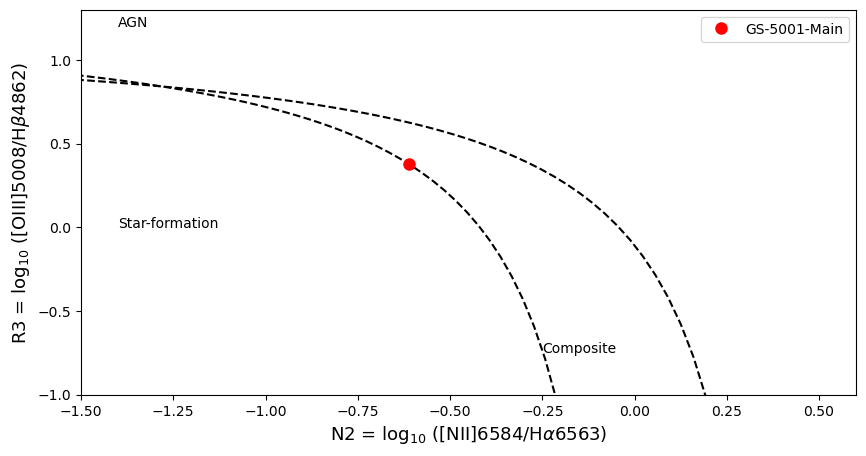

In [18]:
f, (ax) = plt.subplots(1, figsize=(10,5))

x01 = np.linspace(-3,0.4,100)   
x03 = np.linspace(-3,0,100)   

x01 = np.linspace(-3,0.4,100)   
x03 = np.linspace(-3,0,100)
Ka01 = 0.61/(x01-0.47) +1.19
Ka03 = 0.61/(x03-0.05) +1.3


ax.plot(x01, Ka01, 'k--')
ax.plot(x03, Ka03, 'k--')  

ax.text(-1.4, -0., 'Star-formation')
ax.text(-1.4, 1.2, 'AGN')
ax.text(-0.25, -0.75, 'Composite')
    
ax.set_xlim(-1.5,0.6)
ax.set_ylim(-1,1.3)
ax.set_ylabel(r'R3 = log$_{10}$ ([OIII]5008/H$\beta$4862)', fontsize=13)
ax.set_xlabel(r'N2 = log$_{10}$ ([NII]6584/H$\alpha$6563)', fontsize=13)


ax.plot(np.log10(Flux_NII/Flux_hal), np.log10(Flux_OIII/Flux_Hbeta), 'ro', markersize=8, label='GS-5001-Main'  )

ax.legend(loc='best')
plt.show()

In [19]:
print('Flux of the NII line :', Flux_NII)
print('Flux of the Halpha line :', Flux_hal)
print('Flux of the OIII line :', Flux_OIII)
print('Flux of the Hbeta line :',   Flux_Hbeta)

Flux of the NII line : 1.3439342466859291e-17
Flux of the Halpha line : 5.480300076954449e-17
Flux of the OIII line : 3.146370792496217e-17
Flux of the Hbeta line : 1.317198265055217e-17


# Fitting Function for [OIII]+Hbeta

In [20]:
# Defining the model for fitting emission lines around Halpha including of course Halpha itself. 
# Setting up a single Gaussian - will be used later 
def gauss(x, k, mu,FWHM):
    sig = FWHM/2.35482/3e5*mu
    expo= -((x-mu)**2)/(2*sig*sig) 
    y= k* e**expo
    return y

# Setting up the Halpha model:
# First we calculate the observed frame wavelengths of the lines
# Then we calculate the individfual components - Halpha, [NII] and [SII]
# Finally we add all of them together
def OIII_Hbeta(x, z, cont,cont_grad,  OIII_peak, Hbeta_peak, Nar_fwhm):
    OIIIr_wv = 5008.24*(1+z)/1e4    
    OIIIb_wv = 4960.*(1+z)/1e4
    Hbeta_wv = 4862.6*(1+z)/1e4
    
    OIII_nar = gauss(x, OIII_peak, OIIIr_wv, Nar_fwhm) + gauss(x, OIII_peak/2.99, OIIIb_wv, Nar_fwhm)

    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta_wv, Nar_fwhm)
    continuum = cont+x*cont_grad

    return continuum+ OIII_nar + Hbeta_nar

# Extract Emission line parameters from the fit

def flux_calc(index, rest_wave,popt):
                
    wv0 = rest_wave*(1+popt[0])/1e4
    fwhm = popt[-1]

    a = 1./(2*(fwhm/3e5*wv0/2.35482)**2)
    Flux = popt[index]*np.sqrt(np.pi/a) *1e-15 # Remember when I said that we normalize the spectrum earlier? That where the 1e-15 factor comes in

    return Flux


def SNR_calc(index, rest_wave, popt):
    wv0 = rest_wave*(1+popt[0])/1e4
    fwhm = popt[-1]
    fwhm_wv = fwhm/3e5*wv0
    eml_model = gauss(wave,popt[index], wv0 , fwhm) 


    use = np.where( ((wv0-fwhm_wv)<wave) & (wave< (wv0+fwhm_wv)))[0]
    flux_sel = eml_model[use]

    n = len(use)
    SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[100])
    return SNR

def Fitting_OIII_Hbeta(obs_wave, D1_spec, z):

    flux = D1_spec.data[np.invert(D1_spec.mask)]
    wave = obs_wave[np.invert(D1_spec.mask)]
        
    fit_loc = np.where((wave>(5008-300)*(1+z)/1e4)&(wave<(5008+300)*(1+z)/1e4))[0]
        
    sel=  np.where(((wave<(5008+20)*(1+z)/1e4))& (wave>(5008-20)*(1+z)/1e4))[0]
    flux_zoom = flux[sel]
    wave_zoom = wave[sel]
        
    peak_loc = np.ma.argmax(flux_zoom)
    peak = np.ma.max(flux_zoom)

    import astropy.stats as stats
    sigma = stats.sigma_clipped_stats(flux_zoom, sigma=3, maxiters=5)[2]
    # sigma is the standard deviation of the flux in the selected region
    error = np.ones_like(flux) * sigma

    from scipy.optimize import curve_fit

    init_c = [z,np.median(flux),0.01, peak, peak/4, 300. ]

    popt, pcov = curve_fit(OIII_Hbeta, wave[fit_loc], flux[fit_loc], sigma= error[fit_loc], p0= init_c)

    Flux_OIII = flux_calc(3, 5008.24, popt)
    Flux_Hbeta = flux_calc(4, 4862., popt)

    return popt[0], Flux_OIII, Flux_Hbeta, popt, pcov 


print('Best_fit value', Fitting_OIII_Hbeta(obs_wave, D1_spec, z))

Best_fit value (3.4709882901474565, 3.146521577038988e-17, 1.3177403219544167e-17, array([  3.47098829,   4.88276691,  -1.49486891,  18.6298935 ,
         8.03673543, 212.57917305]), array([[ 8.87917277e-11,  3.40970412e-09, -1.52224991e-09,
         3.76552611e-11, -1.18724753e-10, -5.17052751e-09],
       [ 3.40970412e-09,  4.13627316e-02, -1.84436196e-02,
         1.32523590e-04, -1.61272405e-03, -9.33541603e-03],
       [-1.52224991e-09, -1.84436196e-02,  8.23408646e-03,
        -7.58287130e-05,  6.97354886e-04,  3.67310122e-03],
       [ 3.76552611e-11,  1.32523590e-04, -7.58287130e-05,
         1.41817249e-02,  1.86704782e-03, -9.63526428e-02],
       [-1.18724753e-10, -1.61272405e-03,  6.97354886e-04,
         1.86704782e-03,  1.22248156e-02, -4.04829845e-02],
       [-5.17052751e-09, -9.33541603e-03,  3.67310122e-03,
        -9.63526428e-02, -4.04829845e-02,  2.24264510e+00]]))
